In [1]:
# plot some vv vh stuff 
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime, timedelta
#from datetime import timedelta
#from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.ndimage import gaussian_filter, uniform_filter
%matplotlib  widget

In [2]:
# how many dates do we have? 
workdir = '/data/ocp4/LagunaSalada/Data_and_Figs/'
alooks=4
rlooks=20
#cropdir='cropped_9000_20_10000_1780/'
cropdir='cropped_9000_1800_18000_3600/'

LSx=14500
LSy=1800
notLSx=16000
notLSy=1800

# for poster perhaps, 10-31-22
LSx=15000
LSy=1500
notLSx=16500
notLSy=1500

dates = [os.path.basename(x) for x in glob.glob(workdir+cropdir+"SLC_vv/2*")]
dates=sorted(dates)
nd=len(dates)
print(str(nd)+' dates!') 
# convert date strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))

211 dates!


In [3]:
# initializing empty arrays, they are 3 dimensional 
# will contain a layer for each date 
# with layer containing alooks x rlooks pixels from each SLC
LSvv=np.ndarray([len(dates),alooks,rlooks],'complex')
LSvh=np.ndarray([len(dates),alooks,rlooks],'complex')
NotLSvv=np.ndarray([len(dates),alooks,rlooks],'complex')
NotLSvh=np.ndarray([len(dates),alooks,rlooks],'complex')

# pull out the alooks x rlooks box of pixels 
for i in np.arange(nd):
    ds = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", \
                    gdal.GA_ReadOnly)
    LSvv[i,:,:] = ds.GetRasterBand(1).ReadAsArray(LSx-rlooks/2,LSy-alooks/2, \
                                                   rlooks,alooks)
for i in np.arange(nd):
    ds = gdal.Open(workdir+cropdir+"SLC_vh/"+dates[i]+"/"+dates[i]+".slc.full", \
                    gdal.GA_ReadOnly)
    LSvh[i,:,:] = ds.GetRasterBand(1).ReadAsArray(LSx-rlooks/2,LSy-alooks/2, \
                                                   rlooks,alooks)
# do the same for the pixel just outside of LS 
for i in np.arange(nd):
    ds = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", \
                   gdal.GA_ReadOnly)
    NotLSvv[i,:,:] = ds.GetRasterBand(1).ReadAsArray(notLSx-rlooks/2, \
                                                      notLSy-alooks/2,rlooks,alooks)
for i in np.arange(nd):
    ds = gdal.Open(workdir+cropdir+"SLC_vh/"+dates[i]+"/"+dates[i]+".slc.full", \
                   gdal.GA_ReadOnly)
    NotLSvh[i,:,:] = ds.GetRasterBand(1).ReadAsArray(notLSx-rlooks/2, \
                                                      notLSy-alooks/2,rlooks,alooks)

In [4]:
# Calculate average coherence over three SLCs to color each tpc point 
# initialize empty arrays 
cohLSvv = np.zeros([nd-1])
cohLSvh = np.zeros([nd-1])
cohNotLSvv = np.zeros([nd-1])
cohNotLSvh = np.zeros([nd-1])

# calculate coherence for each igram 
for i in np.arange(nd-1): 
    # Using this method: <a b*> / <abs(a b*)>
    # a b*
    ints=LSvv[i,:,:] * np.conj(LSvv[i+1,:,:]) 
    # <a b*> / <abs(a b*)> complex coherence 
    cohLSvv[i]=np.abs(np.mean(ints,axis=(0,1))/np.mean(np.abs(ints),axis=(0,1)))
    
    ints2=NotLSvv[i,:,:] * np.conj(NotLSvv[i+1,:,:])
    cohNotLSvv[i]=np.abs(np.mean(ints2,axis=(0,1))/np.mean(np.abs(ints2),axis=(0,1)))
    
    ints=LSvh[i,:,:] * np.conj(LSvv[i+1,:,:]) 
    cohLSvh[i]=np.abs(np.mean(ints,axis=(0,1))/np.mean(np.abs(ints),axis=(0,1)))
    
    ints2=NotLSvh[i,:,:] * np.conj(NotLSvv[i+1,:,:])
    cohNotLSvh[i]=np.abs(np.mean(ints2,axis=(0,1))/np.mean(np.abs(ints2),axis=(0,1)))

In [6]:
# Read in 2day precipitation data
precip = np.loadtxt('/data/ocp4/LagunaSalada/Data_and_Figs/3_precip/precip_2days.txt', dtype='float')

# BIGGER STORMS
# days with precip > 0.3cm 
print('date \t\t       precip > 0.3cm')
rain_dates = []
for i in np.arange(len(precip)): 
    if precip[i] > 0.3:
        print(str(slc_dates[i])+'    '+str(precip[i])+' cm')
        rain_dates.append(slc_dates[i])

date 		       precip > 0.3cm
2017-05-10 00:00:00    0.33020000000000005 cm
2018-12-07 00:00:00    5.0546 cm
2019-09-27 00:00:00    1.4478 cm
2019-11-20 00:00:00    2.286 cm
2020-02-12 00:00:00    1.1684 cm
2020-03-13 00:00:00    0.40640000000000004 cm
2020-04-12 00:00:00    0.9906 cm
2021-08-11 00:00:00    0.381 cm


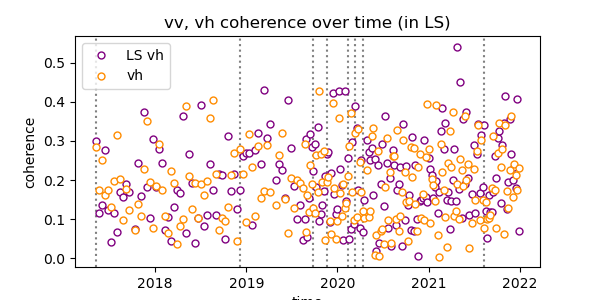

In [7]:
plt.figure(figsize=(6, 3))
#plt.plot(slc_dates[0:-1],cohLSvv,'o',color='purple',markersize=5,label='LS vv')
plt.plot(slc_dates[0:-1],cohLSvh,'o',color='white',mec='purple',markersize=5,label='LS vh',zorder=3)
#plt.plot(slc_dates[0:-1],cohNotLSvv,'o',color='darkorange',markersize=5,label='vv')
plt.plot(slc_dates[0:-1],cohNotLSvh,'o',color='white',mec='darkorange',markersize=5,label='vh',zorder=10)

Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])

#plt.grid('on')
#cbar = plt.colorbar(pad=0.1)
#cbar.set_label('time')
plt.xlabel('time')
plt.ylabel('coherence')
plt.title('vv, vh coherence over time (in LS)')
plt.legend()
plt.show()

In [8]:
# convert datetime objects to number of days (float
# start time 
t0 = slc_dates[0]
print("first date: "+str(t0))
# calculate dt between slcs 
time = np.subtract(slc_dates[0:len(slc_dates)+1],t0)
# these are now timedelta objects
# convert to floats 
time_days = np.zeros([len(slc_dates),1])
for i in range(0,len(slc_dates)):
    time_days[i] = time[i].days
    
ttotal = slc_dates[-1]-slc_dates[0]
print("span of SLCs: "+str(ttotal)+"(= "+str(ttotal.days/365.25)+" years)")

first date: 2017-05-10 00:00:00
span of SLCs: 1704 days, 0:00:00(= 4.6652977412731005 years)


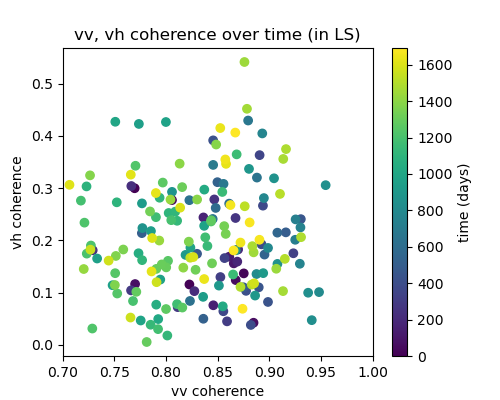

In [9]:
# NOT really a useful plot
plt.figure(figsize=(5, 4))
plt.scatter(cohLSvv,cohLSvh,c=time_days[0:-1])
#plt.scatter(cohNotLSvv[19:50],cohNotLSvh[19:50],c=time_days[19:50]) #FOR JUST 2018 
#plt.grid('on')
cbar = plt.colorbar()
cbar.set_label('time (days)')
plt.xlabel('vv coherence')
plt.ylabel('vh coherence')
plt.xlim([0.7,1])
plt.title('vv, vh coherence over time (in LS)')
plt.show()
# FOR INDIVIDUAL YEARS change plotting range 
# finding which indices are just 2018 
#print(slc_dates[19:50])
# finding which indices are just 2019 
#print(slc_dates[51:90])
# finding which indices are just 2020
#print(slc_dates[91:150])
# finding which indices are just 2021
#print(slc_dates[151:210])

In [11]:
# load in cumulative rainfall file 
precip = np.loadtxt('/data/ocp4/LagunaSalada/Data_and_Figs/3_precip/precip_cumulative.txt') # still in inches
precip2 = np.loadtxt('/data/ocp4/LagunaSalada/Data_and_Figs/3_precip/precip_2days.txt') # still in inches
# convert to cm from inches 
precip = precip*2.54
precip2 = precip2*2.54

In [12]:
# calculate vv coherence/vh coherence 
vvvhCoh = cohLSvv-cohLSvh

In [13]:
print(len(slc_dates))
print(len(vvvhCoh))
print(len(precip))

print('\nindex \tslc date \t\tvvvh coherence \t\tprecip (cm)\n')
for i in np.arange(10):
    print(str(i)+'\t'+str(slc_dates[i])+'\t'+str(vvvhCoh[i])+'\t'+str(precip[i]))
for i in np.arange(10):
    print(str(i+40)+'\t'+str(slc_dates[i+40])+'\t'+str(vvvhCoh[i+40])+'\t'+str(precip[i+40]))

211
210
211

index 	slc date 		vvvh coherence 		precip (cm)

0	2017-05-10 00:00:00	0.4700103538398284	0.8387080000000001
1	2017-05-22 00:00:00	0.7072762167478407	0.0
2	2017-06-03 00:00:00	0.7386552727544995	0.0
3	2017-06-15 00:00:00	0.5288032781319687	0.0
4	2017-06-27 00:00:00	0.7436679346040481	0.0
5	2017-07-09 00:00:00	0.8426224568235384	0.0
6	2017-07-21 00:00:00	0.6538950943402596	0.0
7	2017-08-02 00:00:00	0.3810060462435101	0.0
8	2017-08-14 00:00:00	0.5020783010078403	0.6451600000000001
9	2017-08-26 00:00:00	0.7098359375446375	0.0
40	2018-09-14 00:00:00	0.7007769211572953	0.0
41	2018-09-26 00:00:00	0.5629198060146647	0.0
42	2018-10-08 00:00:00	0.7864258657862249	0.129032
43	2018-10-20 00:00:00	0.538487985268855	0.0
44	2018-11-01 00:00:00	0.7226917358778673	0.0
45	2018-11-13 00:00:00	0.6931515654828619	0.0
46	2018-11-25 00:00:00	0.11600138620953582	0.0
47	2018-12-07 00:00:00	0.4125248459192024	12.838683999999999
48	2018-12-19 00:00:00	0.5861317330860327	0.258064
49	2018-12-31 00:00:

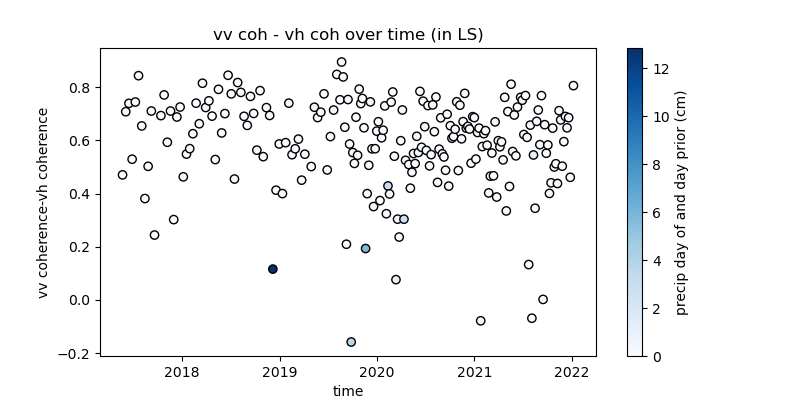

In [14]:
# plot vv-vh with rainfall data as color of data points
plt.figure(figsize=(8, 4))
plt.scatter(slc_dates[1:len(slc_dates)],vvvhCoh,c=precip2[1:len(precip2)],cmap='Blues', \
           edgecolors='k')
#plt.scatter(cohNotLSvv[19:50],cohNotLSvh[19:50],c=time_days[19:50]) #FOR JUST 2018 
cbar = plt.colorbar()
#cbar.set_label('cumulative precipitation (cm)')
cbar.set_label('precip day of and day prior (cm)')
plt.xlabel('time')
plt.ylabel('vv coherence-vh coherence')
#plt.xlim([0.75,1])
plt.title('vv coh - vh coh over time (in LS)')
plt.show()

# EVEN WORST STORM HAS PRETTY GOOD VV COHERENCE IS THAT RIGHT???
#print(slc_dates[0:-1].days,vvvhCoh)

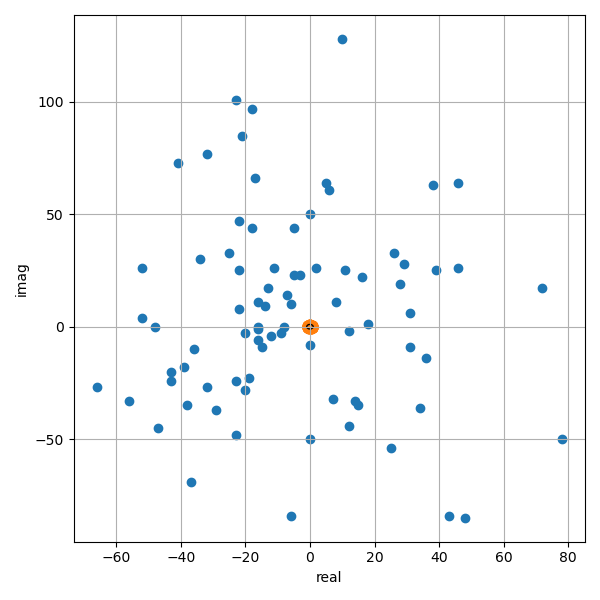

In [15]:
# plot vv and vh values over the small area on imag/real axes 
ax=plt.figure(figsize=(6,6), tight_layout=True)
plt.scatter(np.real(LSvv[0,:,:]),np.imag(LSvv[0,:,:])) # 80 points (4 by 20)
# normalizes the values
plt.scatter(np.real(np.exp(1j*np.angle(LSvv[1,:,:]))),np.imag(np.exp(1j*np.angle(LSvv[1,:,:]))))
circle=plt.Circle([0,0],1,fill=False)
plt.xlabel('real')
plt.ylabel('imag')
#plt.xlim([-10,10])
#plt.ylim([-10,10])
plt.grid()
plt.gca().add_patch(circle)
plt.show()

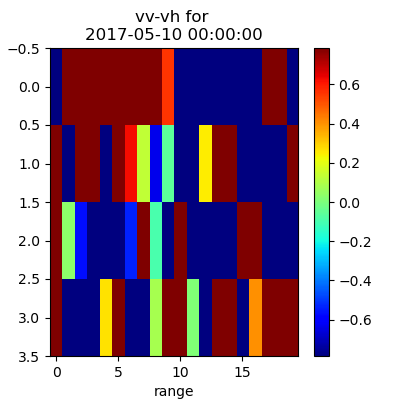

In [16]:
d = 0
plt.figure(figsize=(4, 4))
plt.imshow(np.angle(LSvv[d,:,:])-np.angle(LSvh[d,:,:]),vmin=-np.pi/4, vmax=np.pi/4, cmap='jet', \
           aspect='auto', interpolation='nearest')
plt.ylabel('azimuth')
plt.xlabel('range')
plt.title("vv-vh for \n"+str(slc_dates[d]))
plt.colorbar()
plt.show()

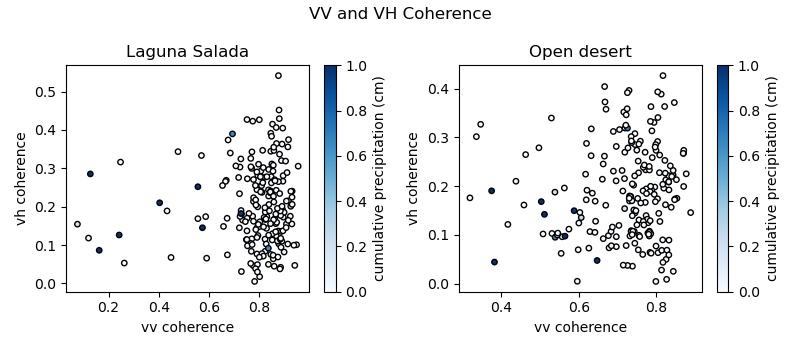

In [18]:
# plot vv-vh with rainfall data as color of data points
plt.figure(figsize=(8,3.5),tight_layout='TRUE')
plt.subplot(1,2,1)
plt.scatter(cohLSvv,cohLSvh,c=precip2[1:len(precip2)],cmap='Blues', \
           edgecolors='k',vmin=0,vmax=1,s=15)
cbar = plt.colorbar(label='cumulative precipitation (cm)')
plt.xlabel('vv coherence')
plt.ylabel('vh coherence')
#plt.xlim([0.75,1])
plt.title('Laguna Salada')
plt.subplot(1,2,2)
plt.scatter(cohNotLSvv,cohNotLSvh,c=precip2[1:len(precip2)],cmap='Blues', \
           edgecolors='k',vmin=0,vmax=1,s=15)
cbar = plt.colorbar(label='cumulative precipitation (cm)')
plt.xlabel('vv coherence')
plt.ylabel('vh coherence')
#plt.xlim([0.75,1])
plt.title('Open desert')
plt.suptitle('VV and VH Coherence')
plt.show()

#plt.savefig("vv_vh_coh.png", transparent=True)